## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_diagonal_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/diagonal/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 13604,
 3: 54416,
 4: 166649,
 5: 574769,
 6: 2125625,
 7: 8502500,
 8: 34010000,
 9: 136040000}

Running 12760 CDFs


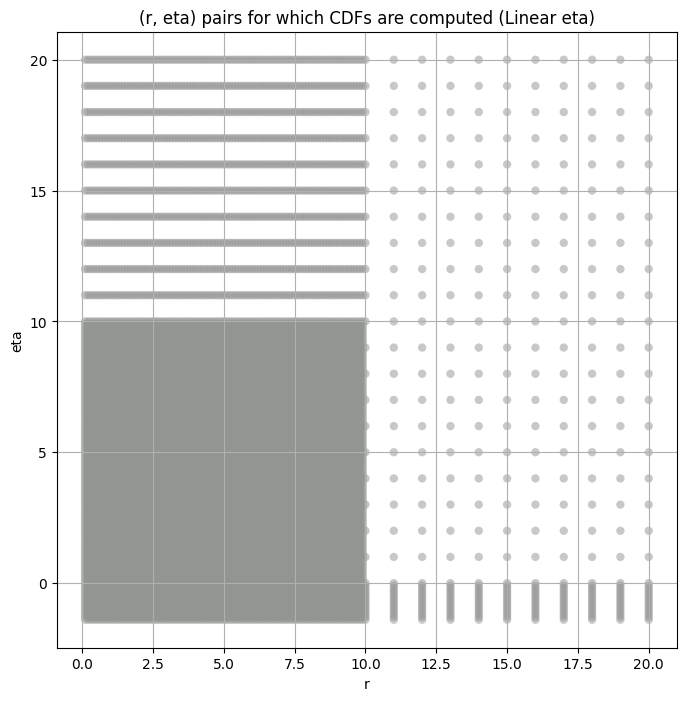

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
layer                                                                  
2      8327.673000  7757.876000  8938.270000    5.539157    3.577629   
3      1202.711800  1089.304400  1329.523300   13.088850    9.018444   
4       481.690160   438.480440   529.395800   11.107946    7.711442   
5       131.085340   119.751950   143.272900   10.210282    7.316702   
6        34.236774    31.205149    37.663357   11.394091    7.350032   
7         8.272123     7.386951     9.387478   19.578783   10.490964   
8         1.799252     1.550236     2.246931   49.430210   14.174963   
9         0.321161     0.266255     0.511087  205.948240   11.414248   

       kurt_upper  total_samples  
layer                             
2        8.374949        13604.0  
3       19.648750        54416.0  
4       20.912415       166649.0  
5       15.086034       574769.0  
6       22.886230      2125625.0  
7       55.204620      8502500.0  
8      222.789520     34010000.0  
9      832.416260    136040000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      8327.673000    8327.672852     7427.411621     6972.285645   
3      1202.711800    1202.711792     1121.317383     1076.950562   
4       481.690160     481.690155      462.794159      451.171814   
5       131.085340     131.085342      126.055855      123.012032   
6        34.236774      34.236774       32.772560       31.932161   
7         8.272123       8.272123        7.791085        7.539207   
8         1.799252       1.799252        1.637104        1.568789   
9         0.321161       0.321161        0.278427        0.267541   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         6618.171387      6325.721191      5856.267090      5480.955566   
3         1041.055908      1010.101807       957.084717       912.742126   
4          441.585571       433.376465       419.061066       406.750122   
5          120.523178       118.336250       114.551659       111.311440   
6           31.257292        30.675667        29.685925        28.846087   
7            7.338736         7.167654         6.879781         6.639316   
8            1.516738         1.473507         1.402921         1.345371   
9            0.259494         0.252910         0.242253         0.233641   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          5159.006348      4878.036133      4631.475586      4013.572510  
3           874.820984       841.157410       810.764587       733.669922  
4           395.883484       386.098663       377.151733       354.166473  
5           108.435951       105.848991       103.499023        97.350807  
6            28.106785        27.439245        26.826555        25.236107  
7             6.429930         6.243674         6.075111         5.644996  
8             1.296344         1.253377         1.215013         1.119159  
9             0.226315         0.219897         0.214158         0.199769

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.009411697832584665 8327.673


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.013578710322648568 7427.4116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.013659293199300426 6972.2856


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.013881664228920787 6618.1714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.014110767540874036 6325.721


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.018129206148551513 5856.267


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.02147335656032745 5480.9556


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.02540122977536252 5159.0063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.029575901909693947 4878.036


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.03359530792873666 4631.4756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.04421488247403649 4013.5725
Number of samples: 13604, Without approximation : 13604.0


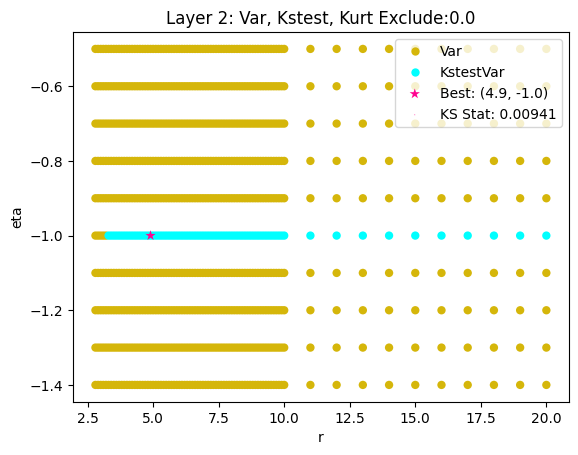

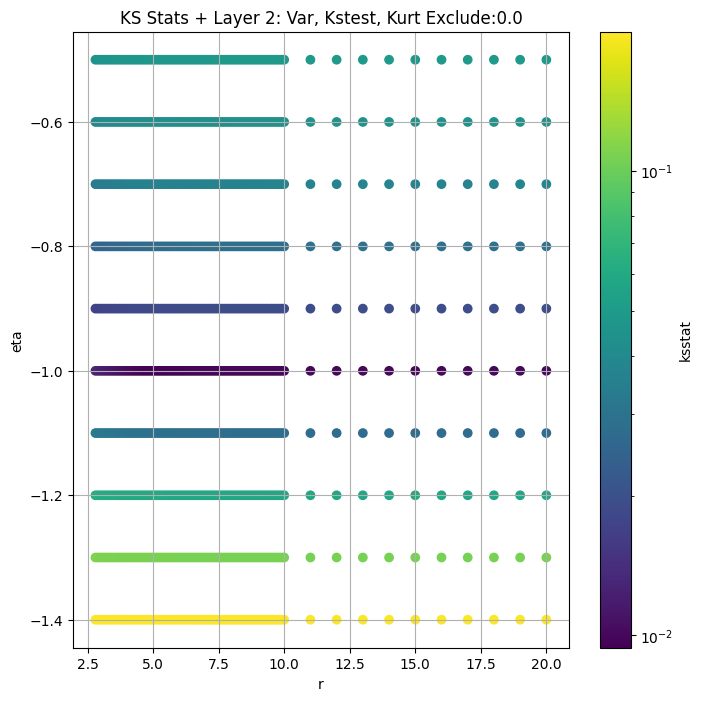

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.22146059982358107 1202.7118


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.22146059982358107 1121.3174


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.22146059982358107 1076.9506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.22146059982358107 1041.0559


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.22146059982358107 1010.1018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.22146059982358107 957.0847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.22146059982358107 912.7421


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.22146059982358107 874.821


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.22146059982358107 841.1574


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.22146059982358107 810.7646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.22146059982358107 733.6699
Number of samples: 54416, Without approximation : 54416.0


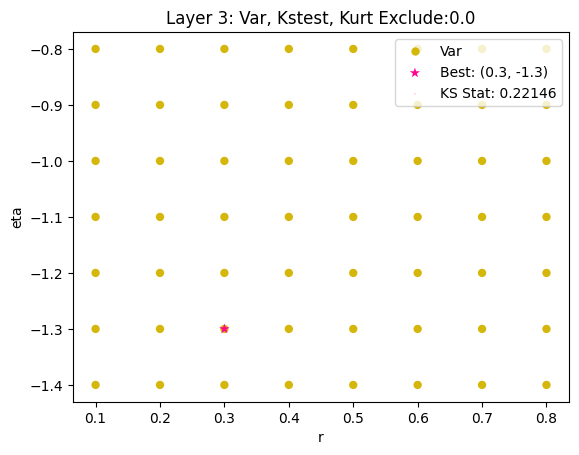

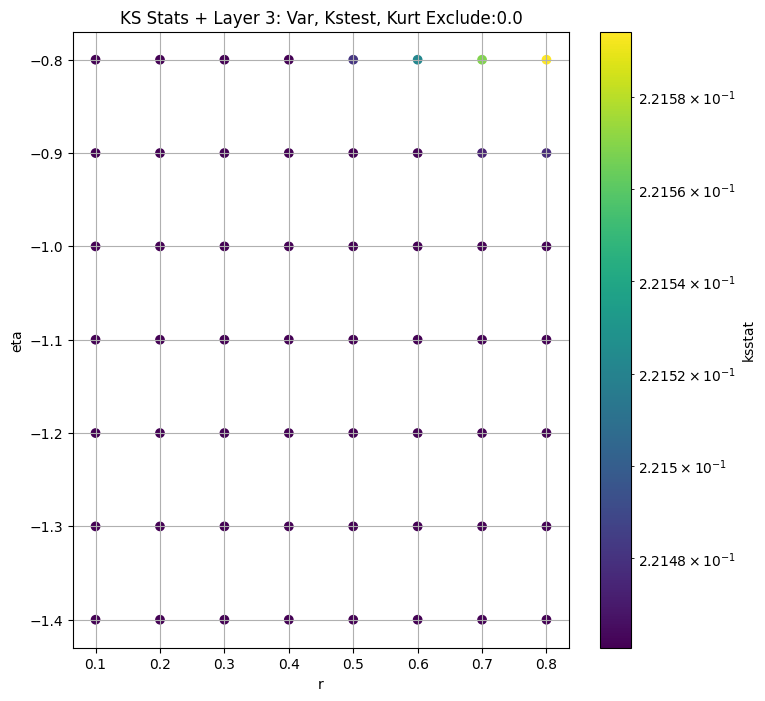

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.13349999999999979 481.69016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.13349999999999979 462.79416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.13349999999999979 451.1718


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.13349999999999979 441.58557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.13349999999999979 433.37646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.13349999999999979 419.06107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.13349999999999979 406.75012


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.13349999999999979 395.88348


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.13349999999999979 386.09866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.13349999999999979 377.15173


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.13349999999999979 354.16647
Number of samples: 100000, Without approximation : 166649.0


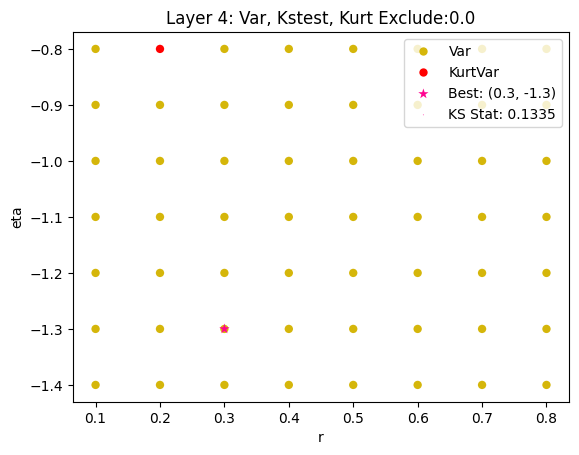

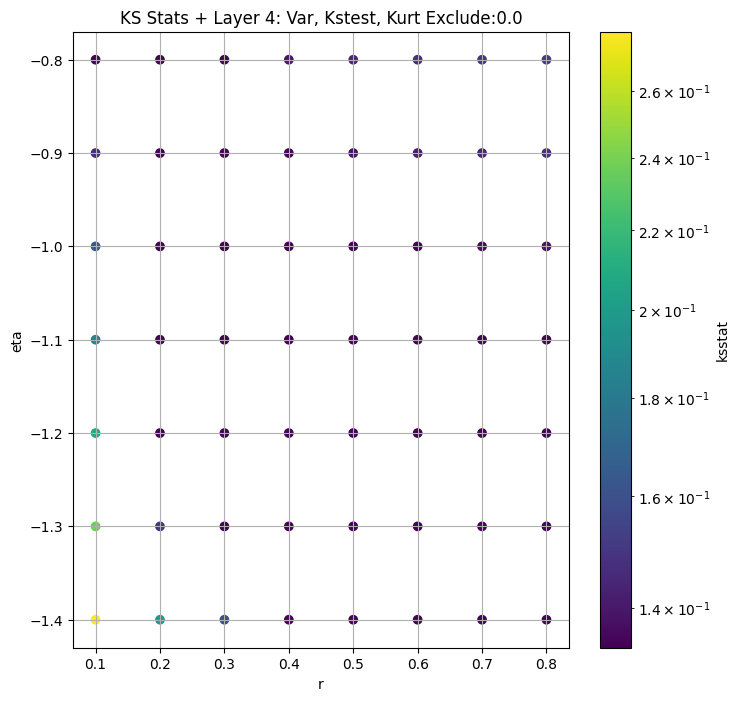

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0743499999999998 131.08534


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.0743499999999998 126.055855


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.0743499999999998 123.01203


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0743499999999998 120.52318


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.0743499999999998 118.33625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0743499999999998 114.55166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.0743499999999998 111.31144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.0743499999999998 108.43595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0743499999999998 105.84899


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.0743499999999998 103.49902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.0743499999999998 97.35081
Number of samples: 100000, Without approximation : 574769.0


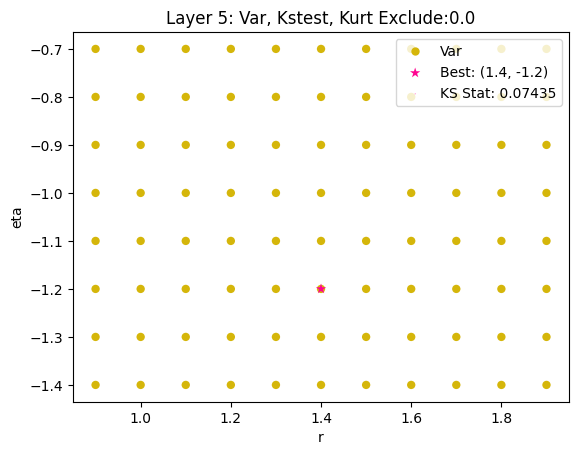

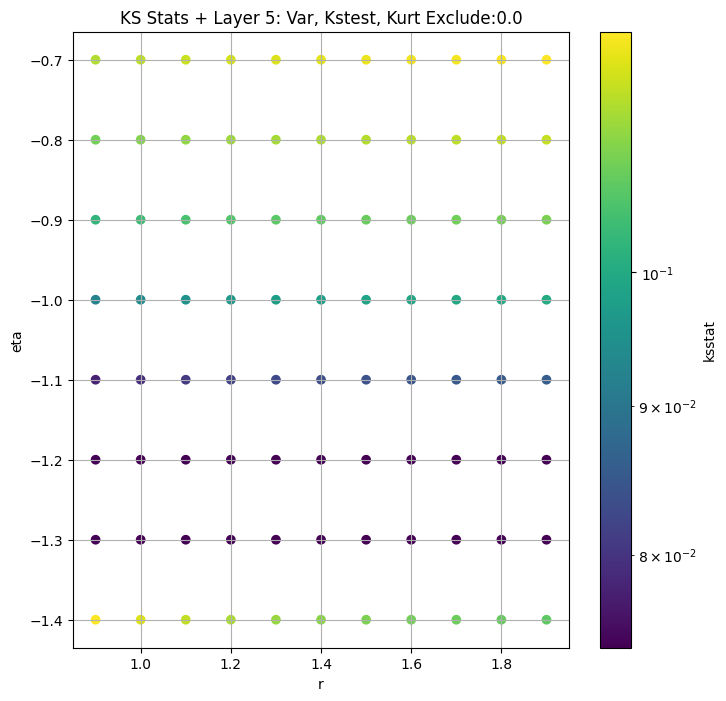

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.009623234522415869 34.236774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.009279486615137666 32.77256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.009196376277348262 31.932161


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.009139121717804732 31.257292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.009091954839100969 30.675667


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.009252098377181772 29.685925


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.009437694801307295 28.846087


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.009566491710144676 28.106785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.00968598073395821 27.439245


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.009798524638402362 26.826555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.010267412666700726 25.236107
Number of samples: 100000, Without approximation : 2125625.0


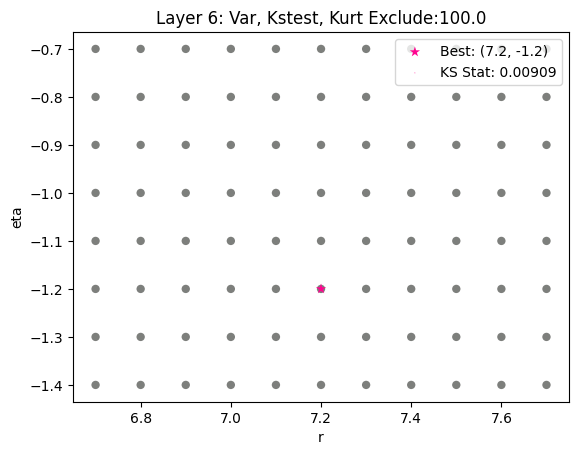

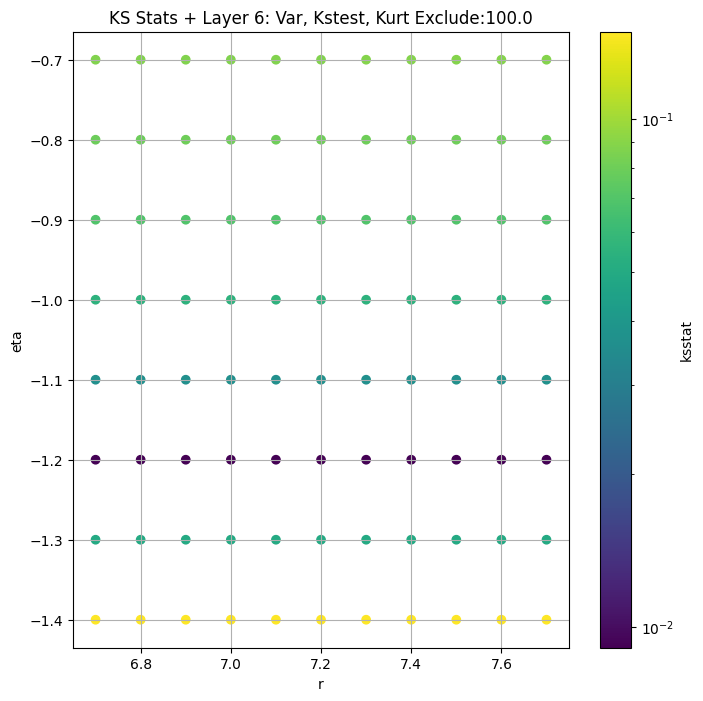

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.010485716551104085 8.272123


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.012335108728705135 7.791085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.011252414986709647 7.5392065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.010222751154019605 7.338736


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.009326657769583302 7.167654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.009024636490583604 6.879781


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.011144562463706431 6.639316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.013070122465794087 6.4299297


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.012135207809262138 6.243674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.011096912352247135 6.075111


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.014196036375057619 5.6449957
Number of samples: 100000, Without approximation : 8502500.0


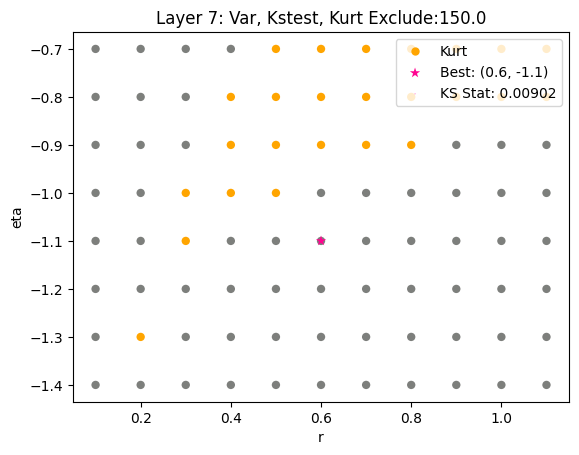

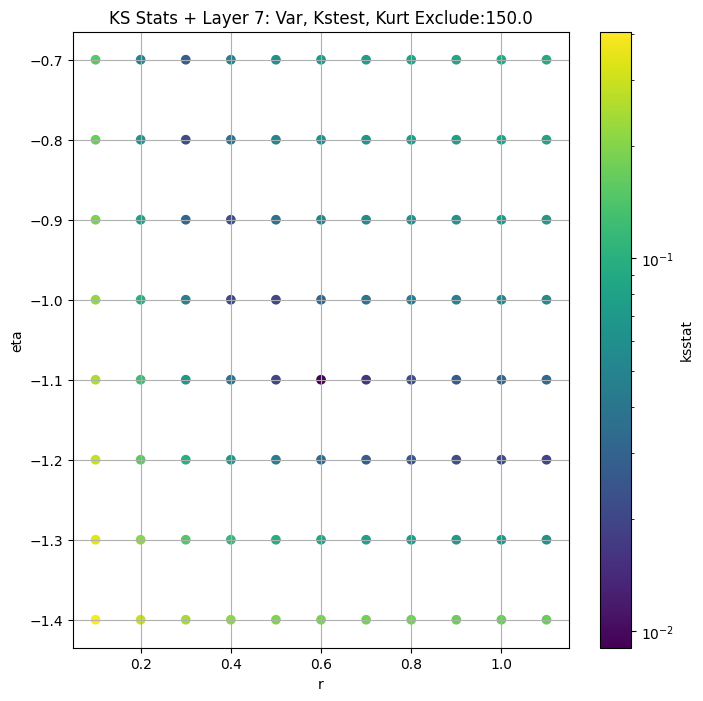

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0074508258144638795 1.7992524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006508879846523041 1.6371044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.007299709187104653 1.5687891


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.008998851854783885 1.5167384


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.008469785321548406 1.473507


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.010147913314971557 1.4029211


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.008859569619801722 1.3453714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.00932593817063243 1.2963438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.009424065328682119 1.2533767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010220118741093187 1.2150134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.01258980578657165 1.1191595
Number of samples: 100000, Without approximation : 34010000.0


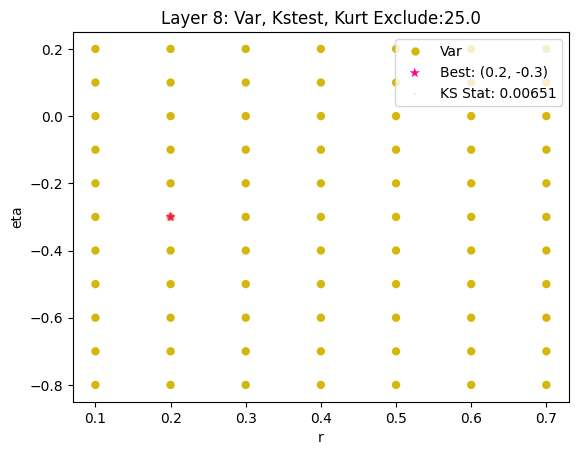

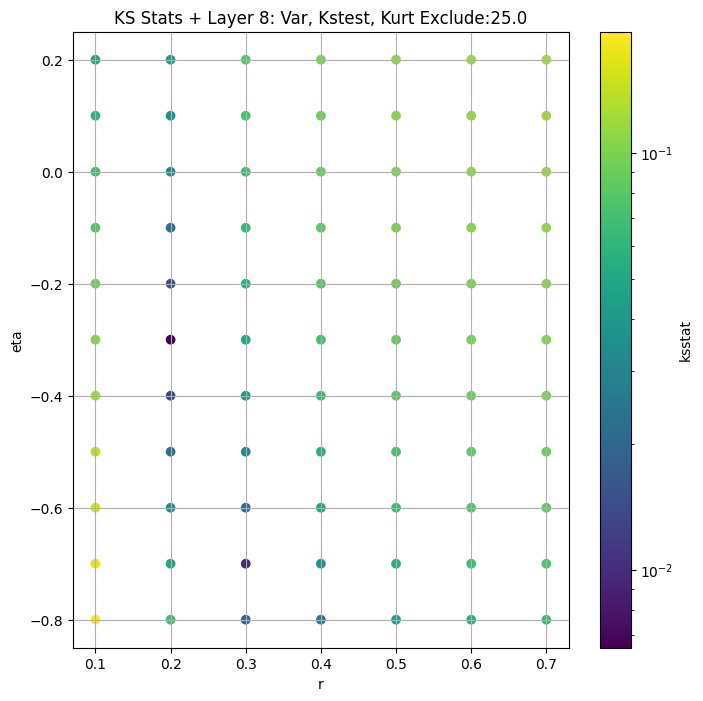

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.008947999368605852 0.32116124


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.008690363343730412 0.27842712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.008841995221723464 0.2675414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.008624763622859632 0.25949436


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.008562207844308 0.25290975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.008800512448702169 0.24225312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.009023926306837904 0.23364066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.008707424382196904 0.22631536


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008526779718338151 0.21989693


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.008377533540125659 0.21415839


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009016341273699824 0.19976945
Number of samples: 100000, Without approximation : 136040000.0


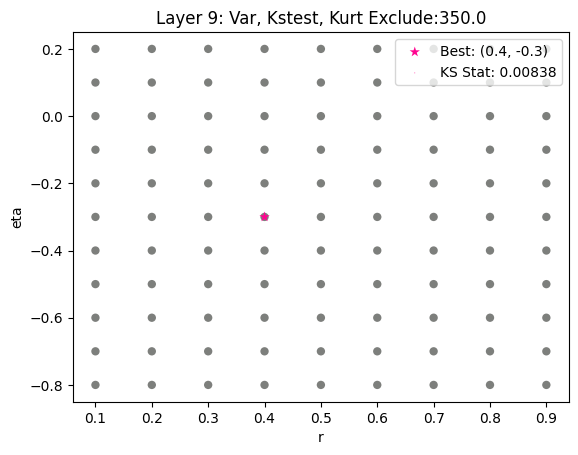

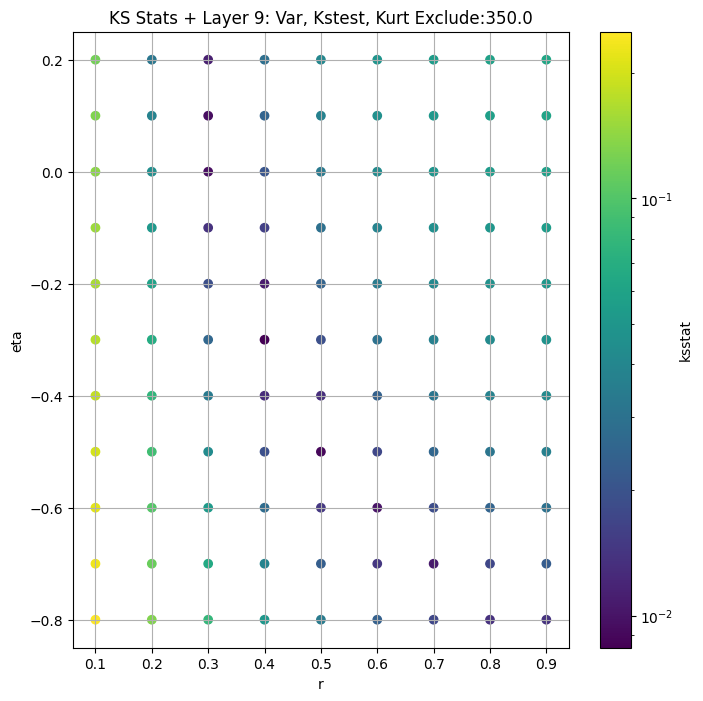

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
layer                                                                  
2      8327.673000  7757.876000  8938.270000    5.539157    3.577629   
3      1202.711800  1089.304400  1329.523300   13.088850    9.018444   
4       481.690160   438.480440   529.395800   11.107946    7.711442   
5       131.085340   119.751950   143.272900   10.210282    7.316702   
6        34.236774    31.205149    37.663357   11.394091    7.350032   
7         8.272123     7.386951     9.387478   19.578783   10.490964   
8         1.799252     1.550236     2.246931   49.430210   14.174963   
9         0.321161     0.266255     0.511087  205.948240   11.414248   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        8.374949        13604.0             0.009412        4.9         -1.0   
3       19.648750        54416.0             0.221461        0.3         -1.3   
4       20.912415       166649.0             0.133500        0.3         -1.3   
5       15.086034       574769.0             0.074350        1.4         -1.2   
6       22.886230      2125625.0             0.009092        7.2         -1.2   
7       55.204620      8502500.0             0.009025        0.6         -1.1   
8      222.789520     34010000.0             0.006509        0.2         -0.3   
9      832.416260    136040000.0             0.008378        0.4         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       26486.933358                     0.0         8327.673000   
3         271.435602                     0.0         1202.711800   
4         108.710880                     0.0          481.690160   
5         534.504193                     0.0          131.085340   
6         140.705393                   100.0           30.675667   
7           7.824397                   150.0            6.879781   
8           0.000054                    25.0            1.637104   
9           0.008183                   350.0            0.214158   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.011632  
3                     0.005819  
4                     0.003326  
5                     0.001791  
6                     0.000931  
7                     0.000466  
8                     0.000233  
9                     0.000116

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.01457858561659564, var: 6325.72119140625


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.01311958249766021, var: 6618.17138671875


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.012338328180640401, var: 6972.28564453125


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.01159584577537065, var: 7427.41162109375


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.009411697832584665, var: 8327.6728515625
Number of samples: 13604, Without approximation : 13604.0


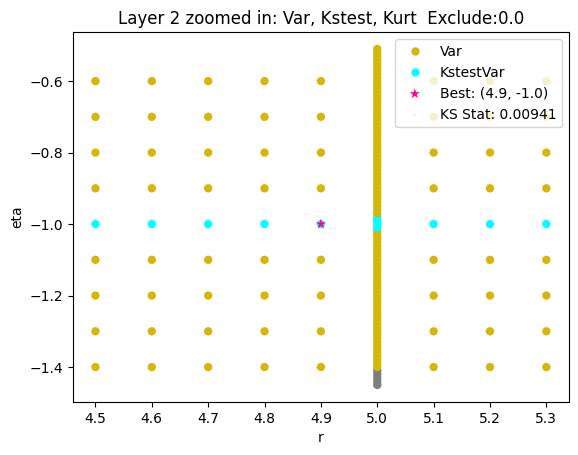

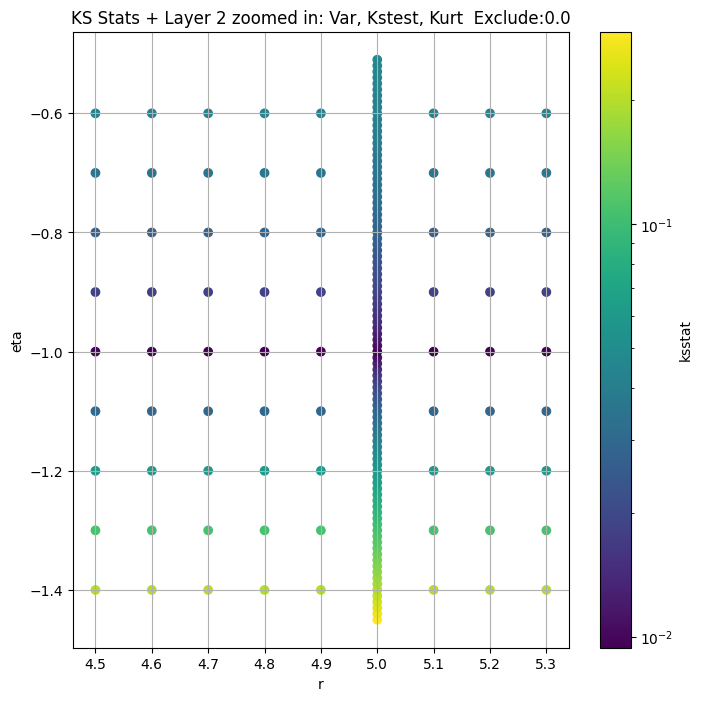

Layer 3


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.22146059982358107, var: 1010.101806640625


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.22146059982358107, var: 1041.055908203125


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.22146059982358107, var: 1076.9505615234375


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.22146059982358107, var: 1121.3173828125


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.22146059982358107, var: 1202.7117919921875
Number of samples: 54416, Without approximation : 54416.0


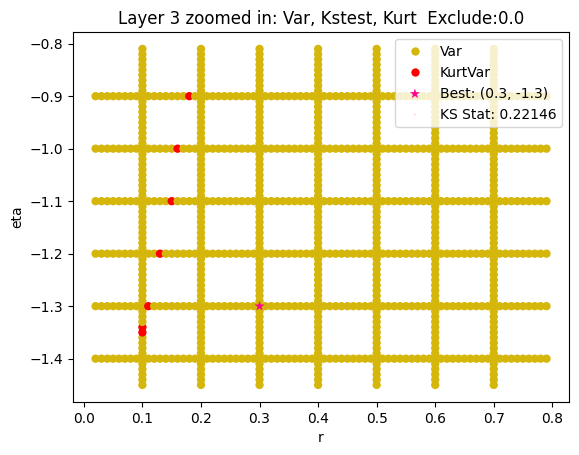

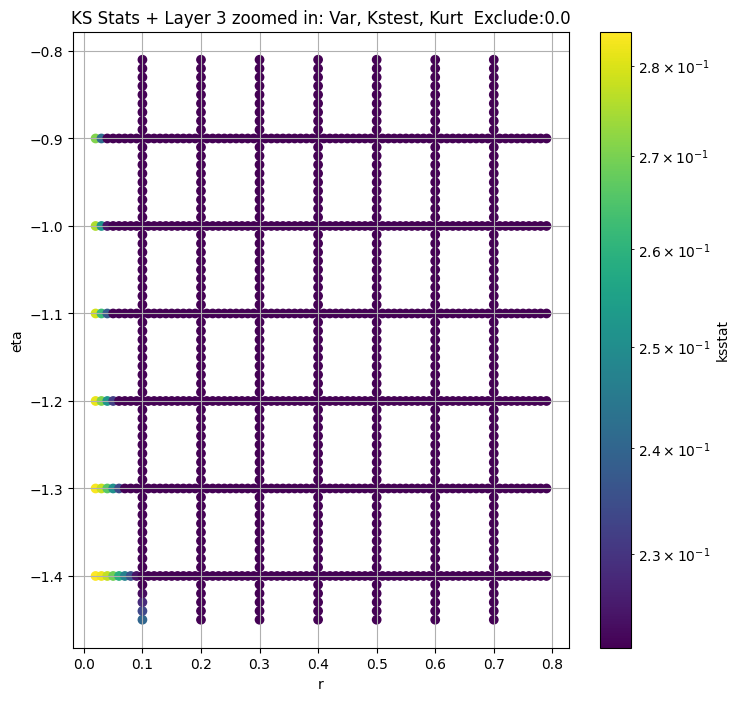

Layer 4


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.13349999999999979, var: 433.37646484375


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.13349999999999979, var: 441.5855712890625


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.13349999999999979, var: 451.17181396484375


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.13349999999999979, var: 462.7941589355469


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.13349999999999979, var: 481.6901550292969
Number of samples: 100000, Without approximation : 166649.0


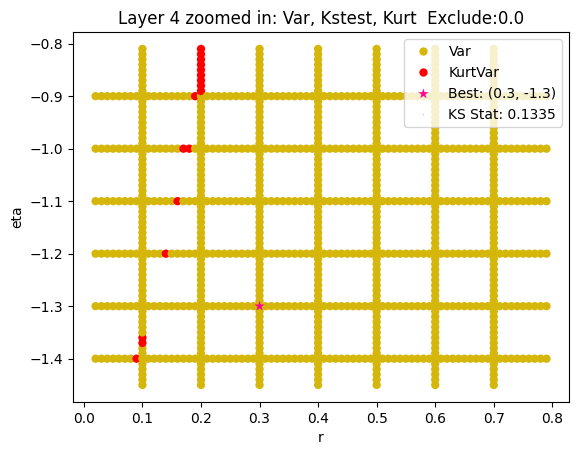

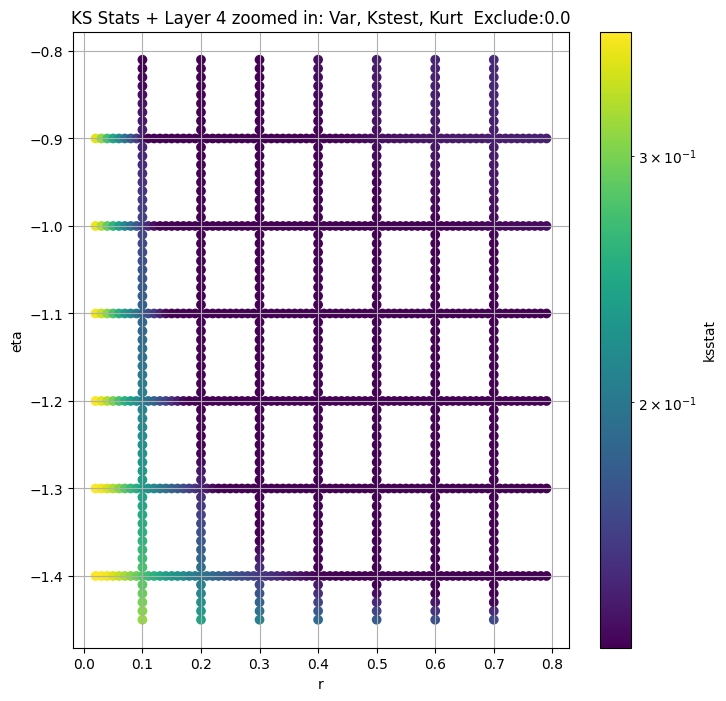

Layer 5


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.07434999999999975, var: 118.33625030517578


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.07434999999999975, var: 120.52317810058594


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.07434999999999975, var: 123.01203155517578


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.07434999999999975, var: 126.05585479736328


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.07434999999999975, var: 131.08534240722656
Number of samples: 100000, Without approximation : 574769.0


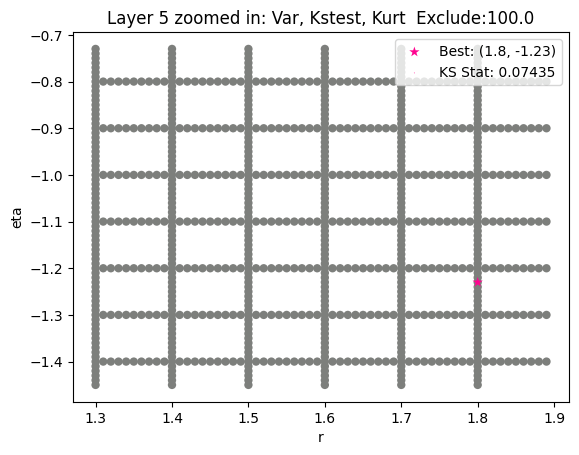

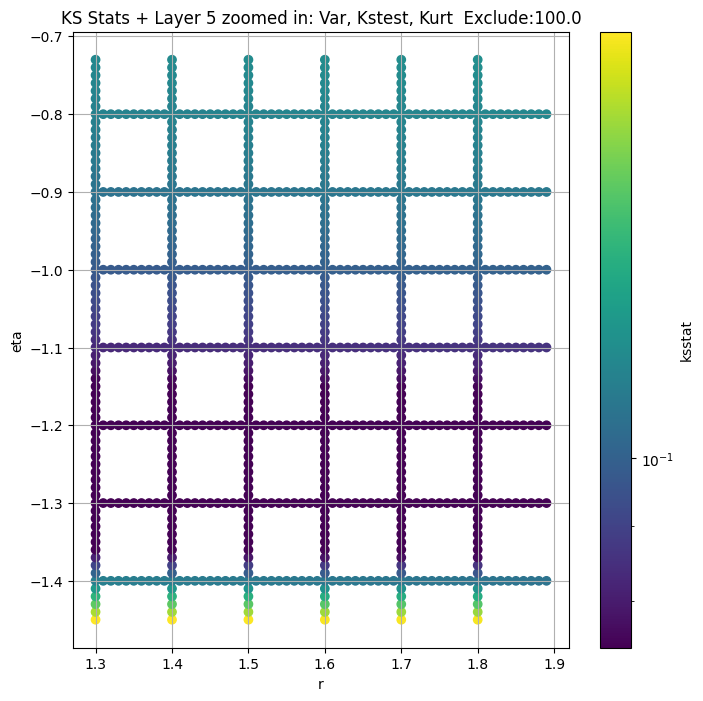

Layer 6


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 6, 100.0 + 100 = 200, ksstat: 0.009488924349255745, var: 28.846086502075195


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 6, 100.0 + 75 = 175, ksstat: 0.009394995418316565, var: 29.251596450805664


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 6, 100.0 + 50 = 150, ksstat: 0.009296239567527675, var: 29.685924530029297


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 6, 100.0 + 25 = 125, ksstat: 0.009191047176551725, var: 30.15787124633789


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 6, 100.0 + 0 = 100, ksstat: 0.009091954839100969, var: 30.67566680908203


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 6, 100.0 + -25 = 75, ksstat: 0.010189168740363547, var: 31.257291793823242


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 6, 100.0 + -50 = 50, ksstat: 0.010805723896011865, var: 31.932161331176758


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 6, 100.0 + -75 = 25, ksstat: 0.011683715032685796, var: 32.772560119628906


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 6, 100.0 + -100 = 0, ksstat: 0.012953057365659063, var: 34.23677444458008
Number of samples: 100000, Without approximation : 2125625.0


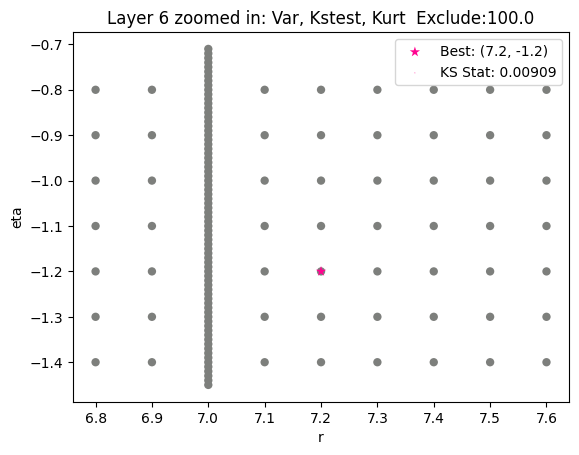

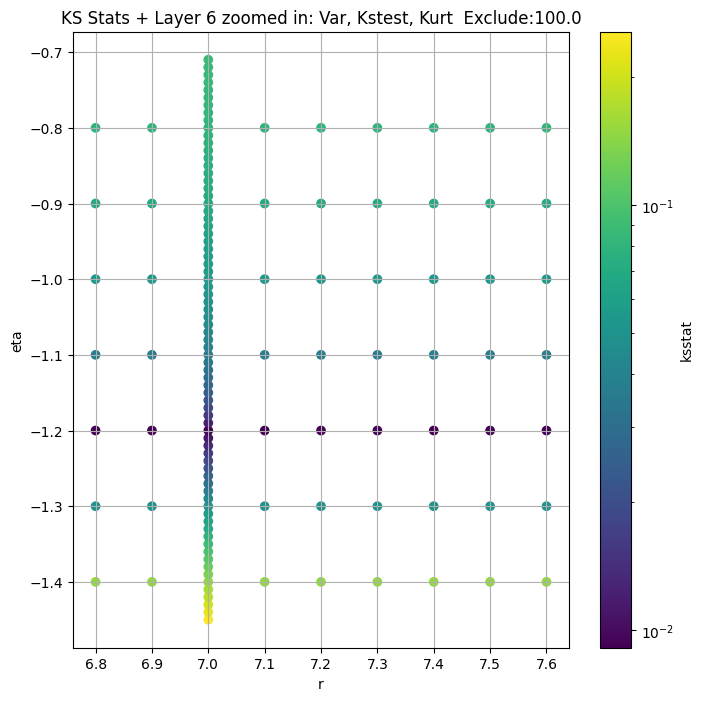

Layer 7


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.009550660399938904, var: 6.429929733276367


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.009344100138737266, var: 6.53129768371582


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.00912615810457551, var: 6.639316082000732


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.008911879202551709, var: 6.754946231842041


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.008706745746485889, var: 6.8797807693481445


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.008520092388159095, var: 7.0162739753723145


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.00837878909753298, var: 7.167654037475586


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.008459584141311094, var: 7.338736057281494


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.008517620102026724, var: 7.539206504821777
Number of samples: 100000, Without approximation : 8502500.0


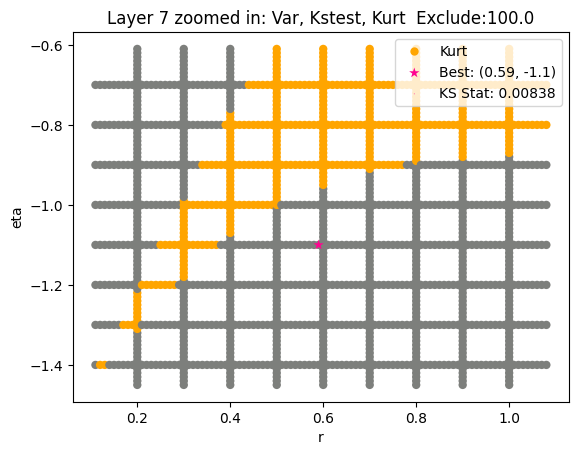

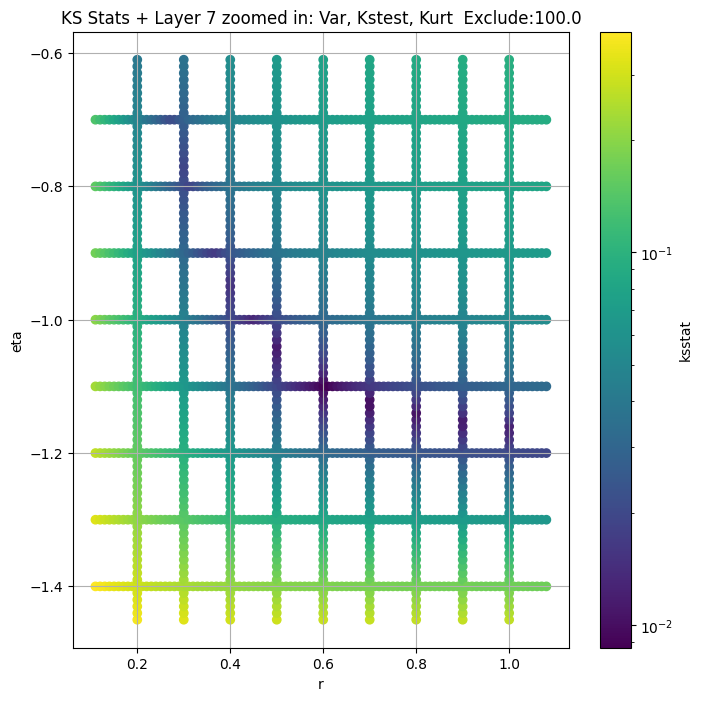

Layer 8


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.007963540566970795, var: 1.436139464378357


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.007096917066681807, var: 1.473507046699524


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.007288245034599683, var: 1.5167384147644043


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.006448425380494616, var: 1.5687891244888306


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.006508879846523041, var: 1.6371043920516968


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.0070815946319389145, var: 1.7992523908615112
Number of samples: 100000, Without approximation : 34010000.0


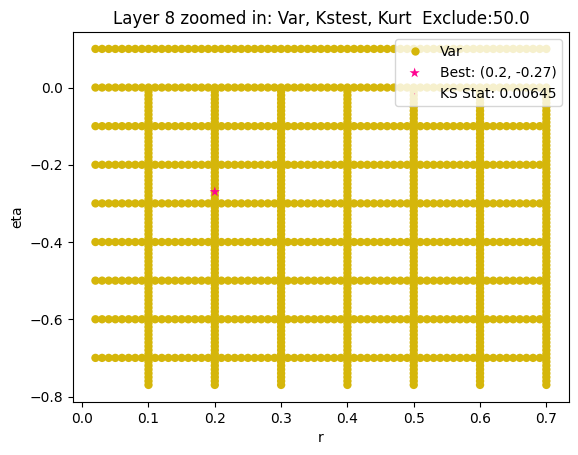

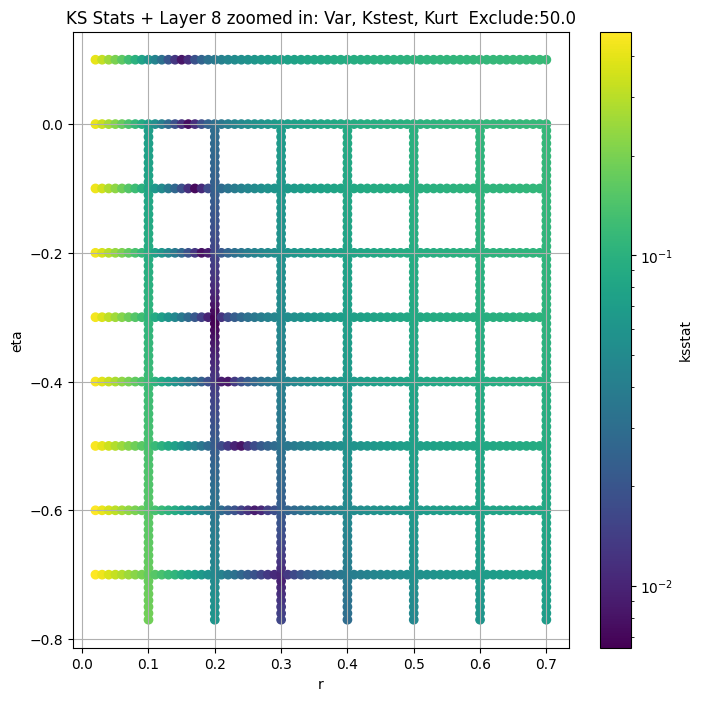

Layer 9


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 100 = 450, ksstat: 0.008396719795290497, var: 0.20418275892734528


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 75 = 425, ksstat: 0.008384596701203284, var: 0.20651938021183014


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 50 = 400, ksstat: 0.008387976596332725, var: 0.20895402133464813


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 25 = 375, ksstat: 0.008392941430121648, var: 0.2114965319633484


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + 0 = 350, ksstat: 0.008377533540125659, var: 0.21415838599205017


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + -25 = 325, ksstat: 0.008382886772298703, var: 0.21695314347743988


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + -50 = 300, ksstat: 0.008390516300401774, var: 0.21989692747592926


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + -75 = 275, ksstat: 0.008397592089599892, var: 0.22300973534584045


  0%|          | 0/1368 [00:00<?, ?it/s]

Finding Minimum after computing 1368 CDFs
layer 9, 350.0 + -100 = 250, ksstat: 0.008403968235658199, var: 0.22631536424160004
Number of samples: 100000, Without approximation : 136040000.0


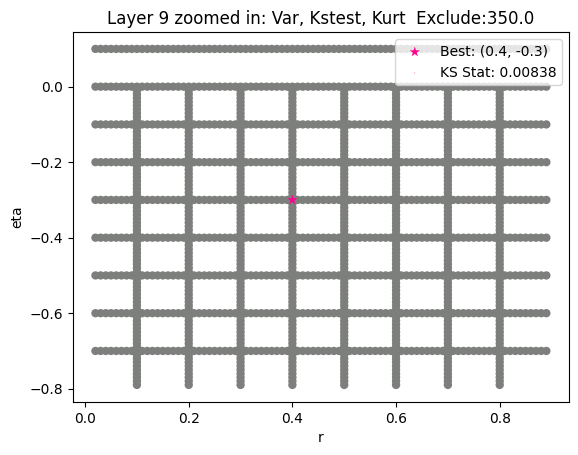

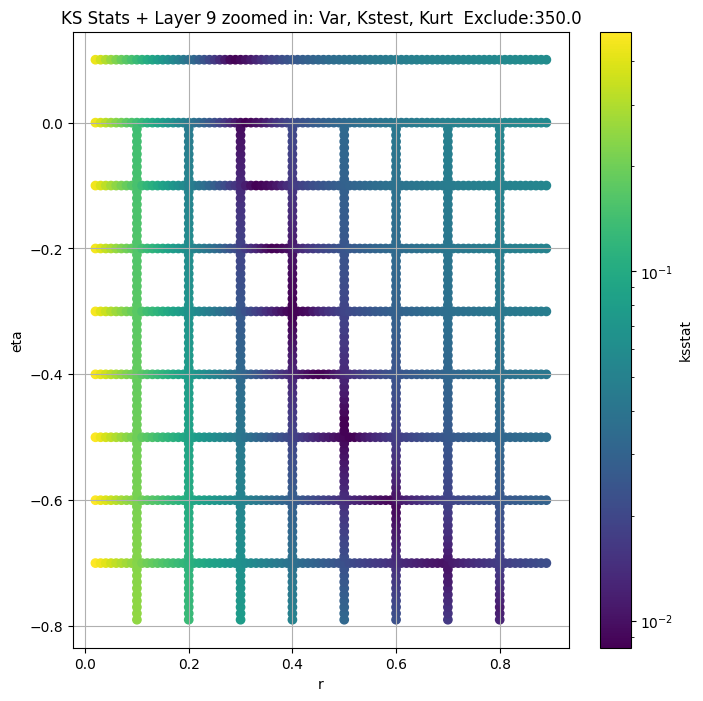

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
layer                                                                  
2      8327.673000  7757.876000  8938.270000    5.539157    3.577629   
3      1202.711800  1089.304400  1329.523300   13.088850    9.018444   
4       481.690160   438.480440   529.395800   11.107946    7.711442   
5       131.085340   119.751950   143.272900   10.210282    7.316702   
6        34.236774    31.205149    37.663357   11.394091    7.350032   
7         8.272123     7.386951     9.387478   19.578783   10.490964   
8         1.799252     1.550236     2.246931   49.430210   14.174963   
9         0.321161     0.266255     0.511087  205.948240   11.414248   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        8.374949        13604.0             0.009412        4.9         -1.0   
3       19.648750        54416.0             0.221461        0.3         -1.3   
4       20.912415       166649.0             0.133500        0.3         -1.3   
5       15.086034       574769.0             0.074350        1.4         -1.2   
6       22.886230      2125625.0             0.009092        7.2         -1.2   
7       55.204620      8502500.0             0.009025        0.6         -1.1   
8      222.789520     34010000.0             0.006509        0.2         -0.3   
9      832.416260    136040000.0             0.008378        0.4         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       26486.933358                     0.0         8327.673000   
3         271.435602                     0.0         1202.711800   
4         108.710880                     0.0          481.690160   
5         534.504193                     0.0          118.336250   
6         140.705393                   100.0           30.675667   
7           7.824397                   150.0            7.167654   
8           0.000054                    25.0            1.568789   
9           0.008183                   350.0            0.214158   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.011632          0.009412    4.90     -1.00   
3                     0.005819          0.221461    0.30     -1.30   
4                     0.003326          0.133500    0.30     -1.30   
5                     0.001791          0.074350    1.80     -1.23   
6                     0.000931          0.009092    7.20     -1.20   
7                     0.000466          0.008379    0.59     -1.10   
8                     0.000233          0.006448    0.20     -0.27   
9                     0.000116          0.008378    0.40     -0.30   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      26486.933358                  0.0        20406  
3        271.435602                  0.0           37  
4        108.710880                  0.0          100  
5        570.898272                100.0          315  
6        140.705393                100.0        22437  
7          7.835647                100.0        26595  
8          0.000047                 50.0        44883  
9          0.008183                350.0        26595

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

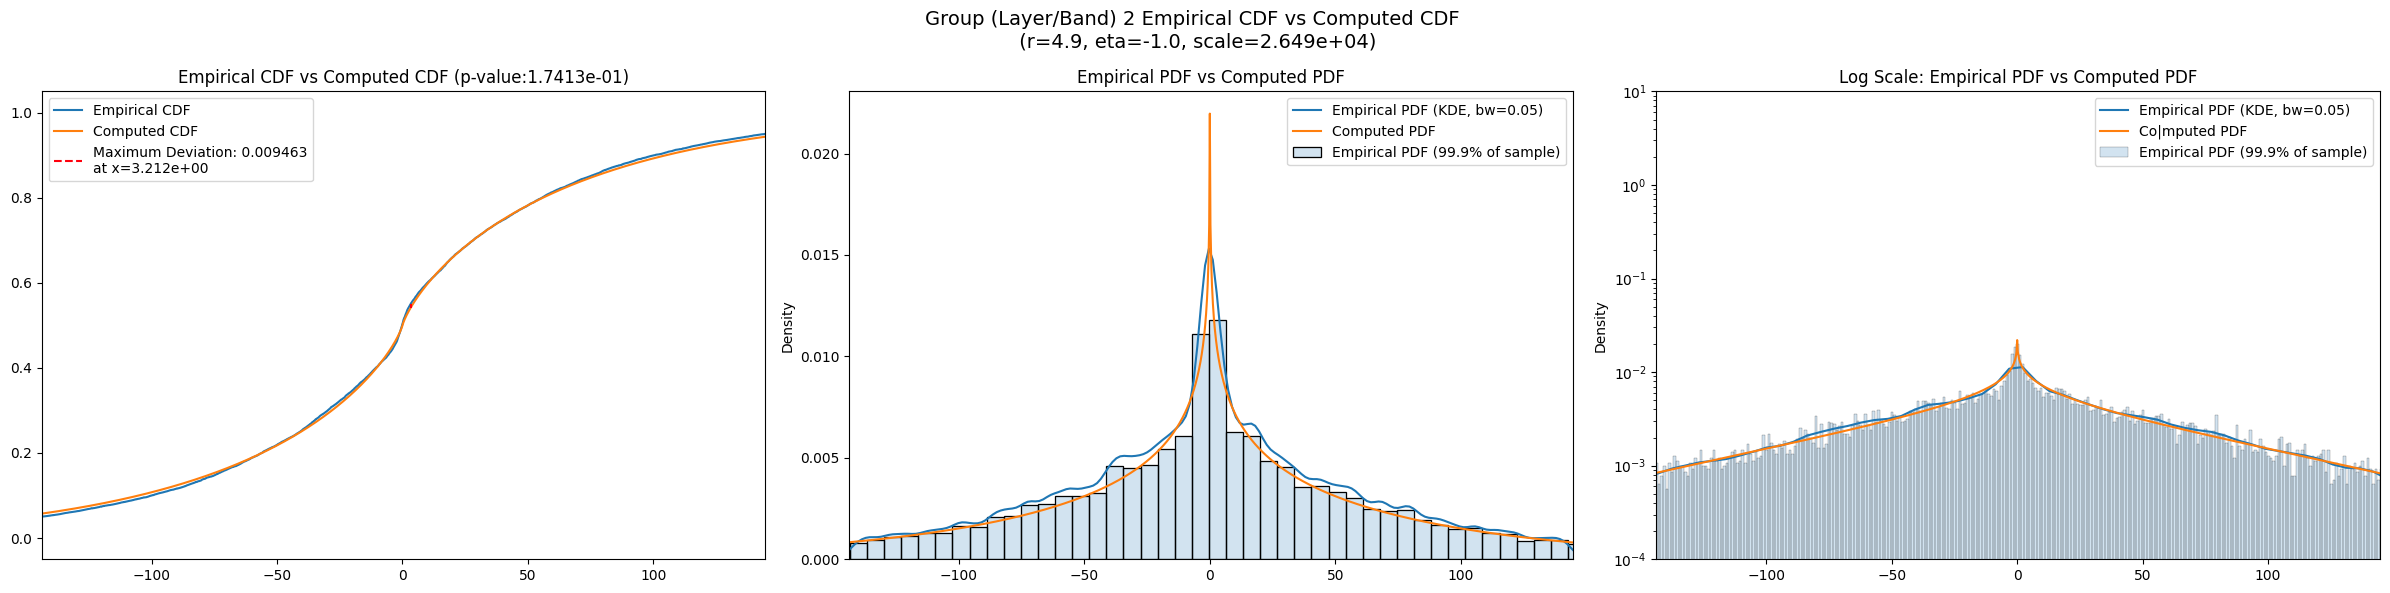

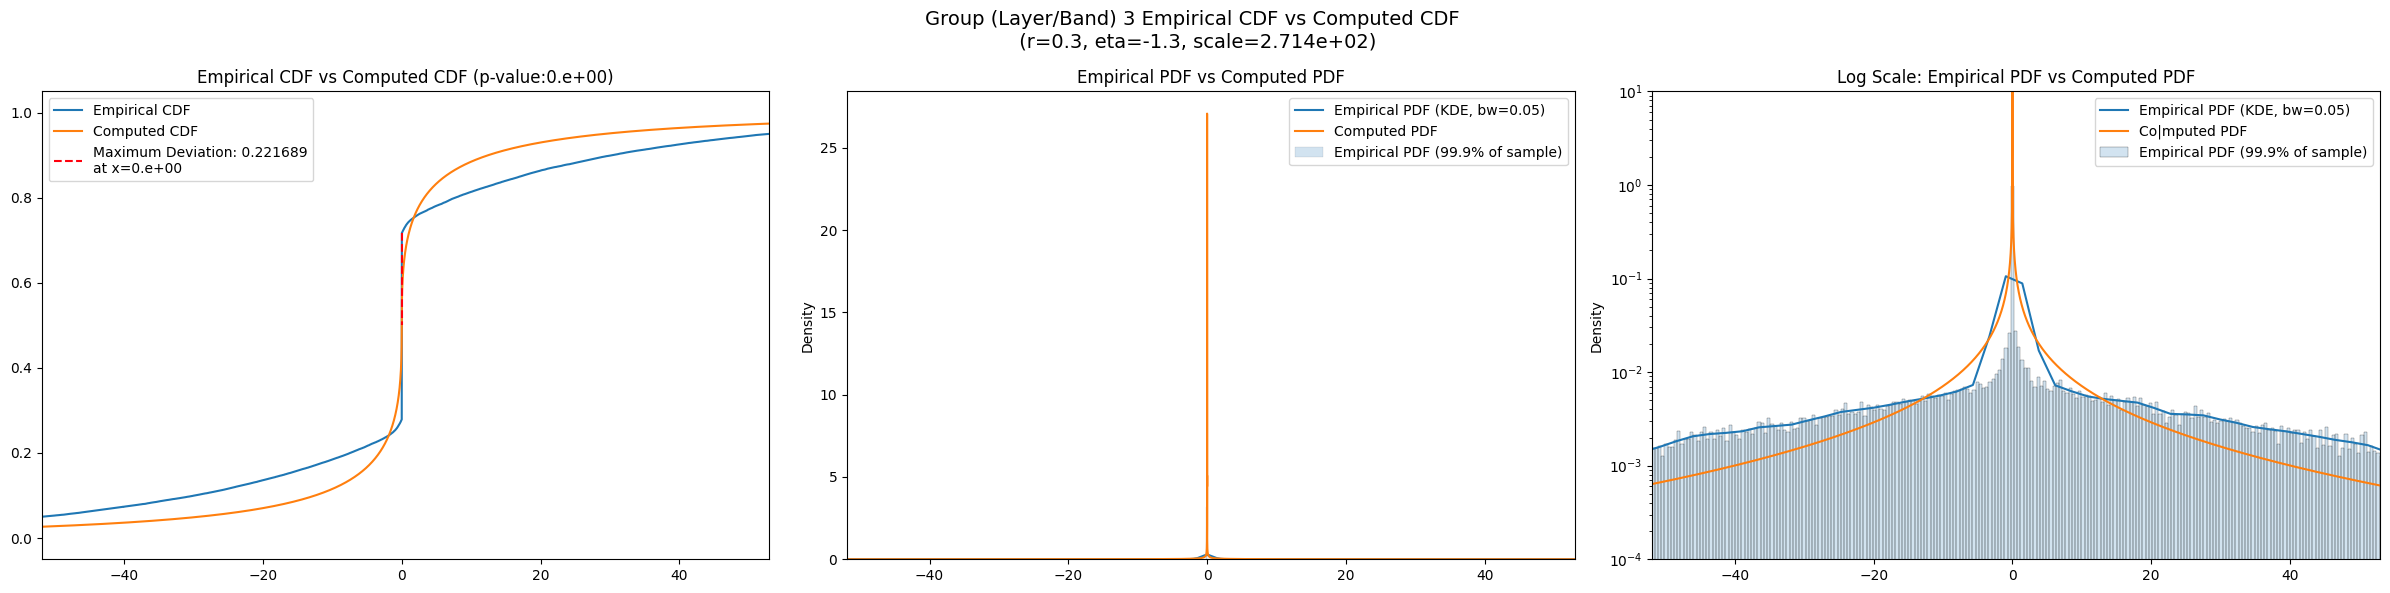

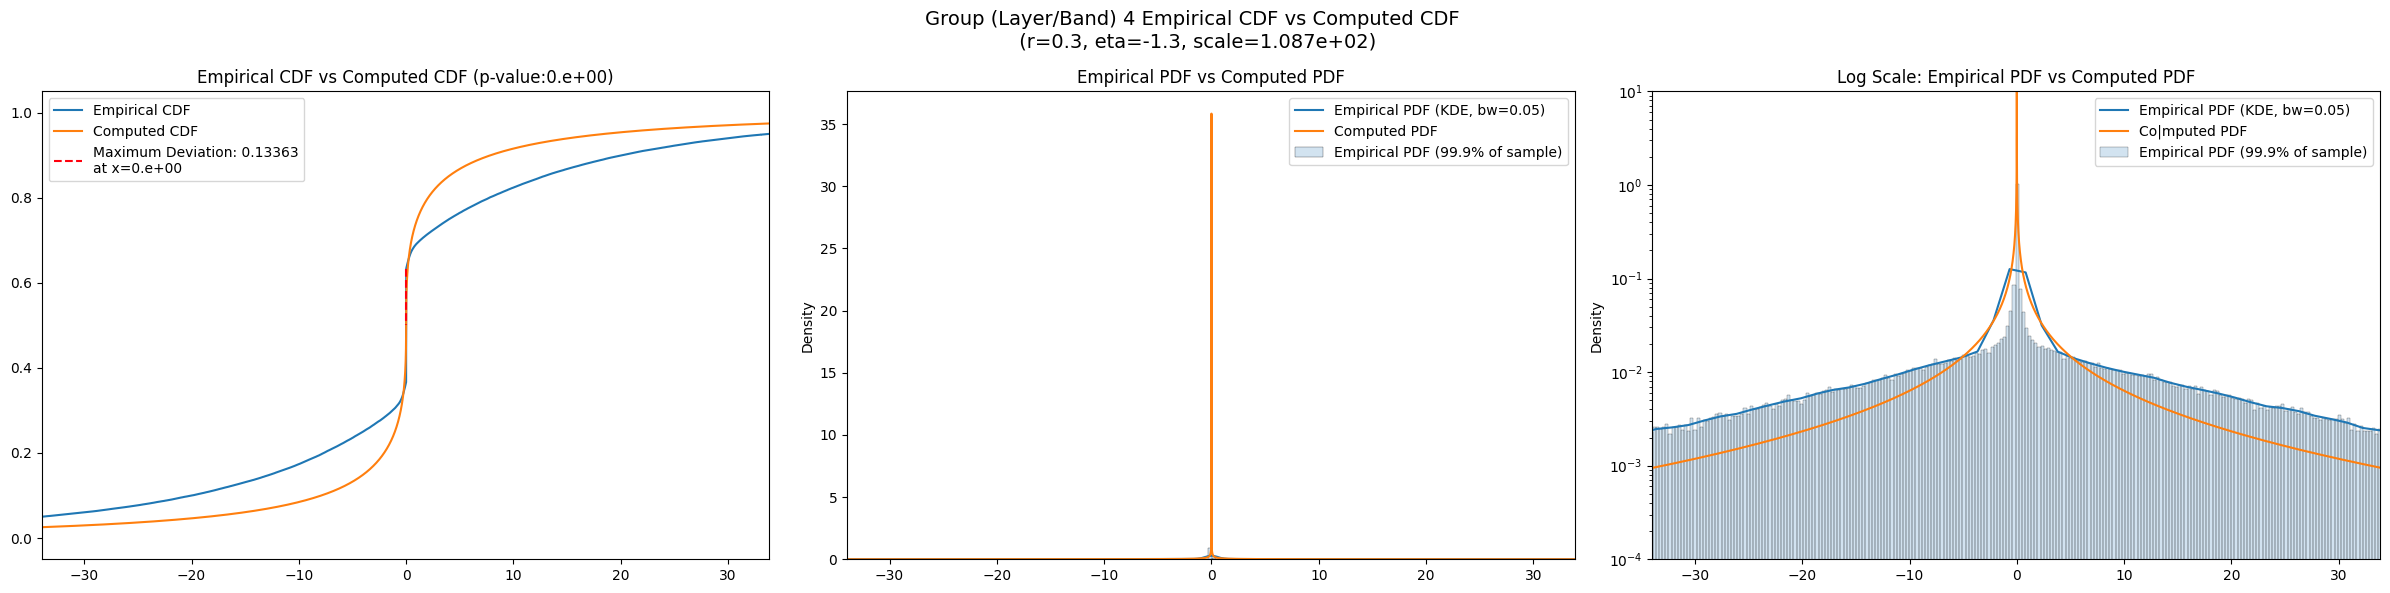

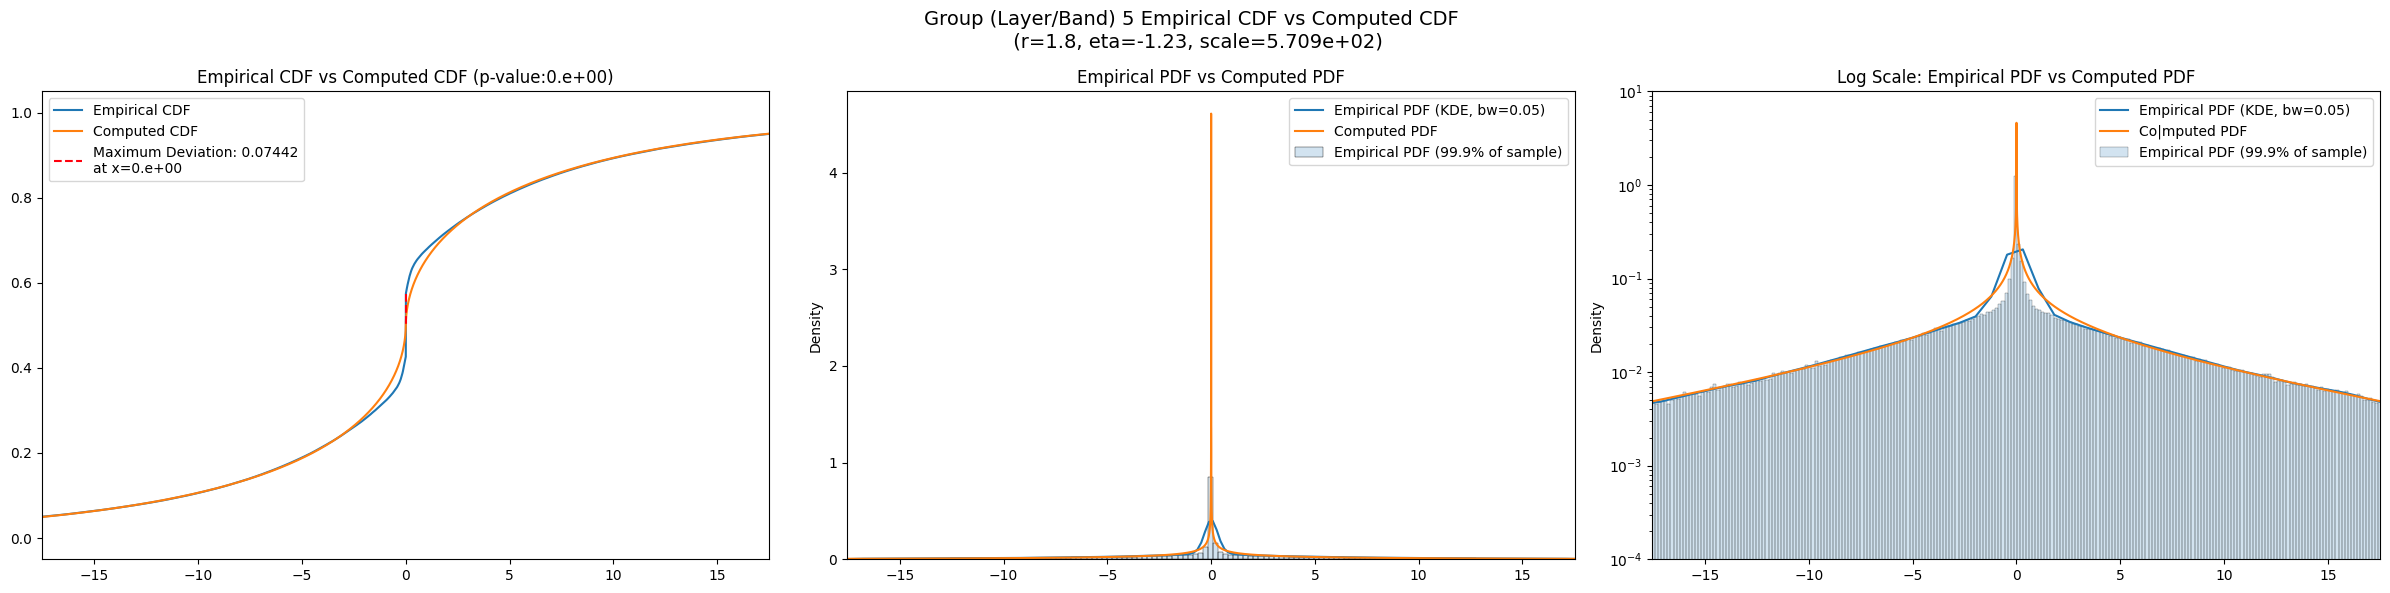

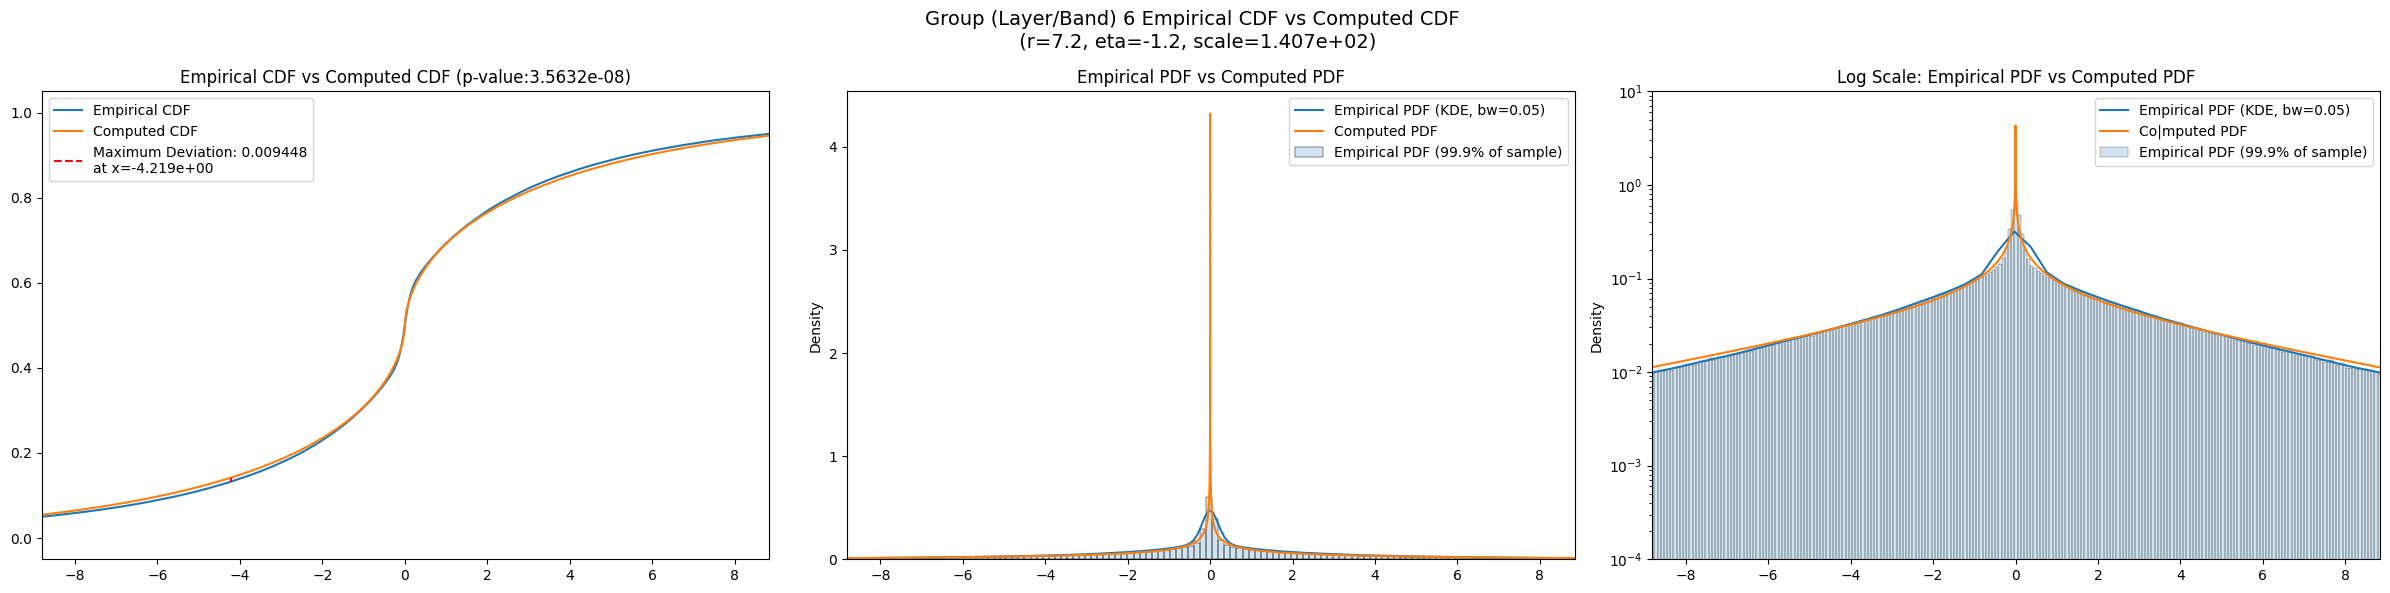

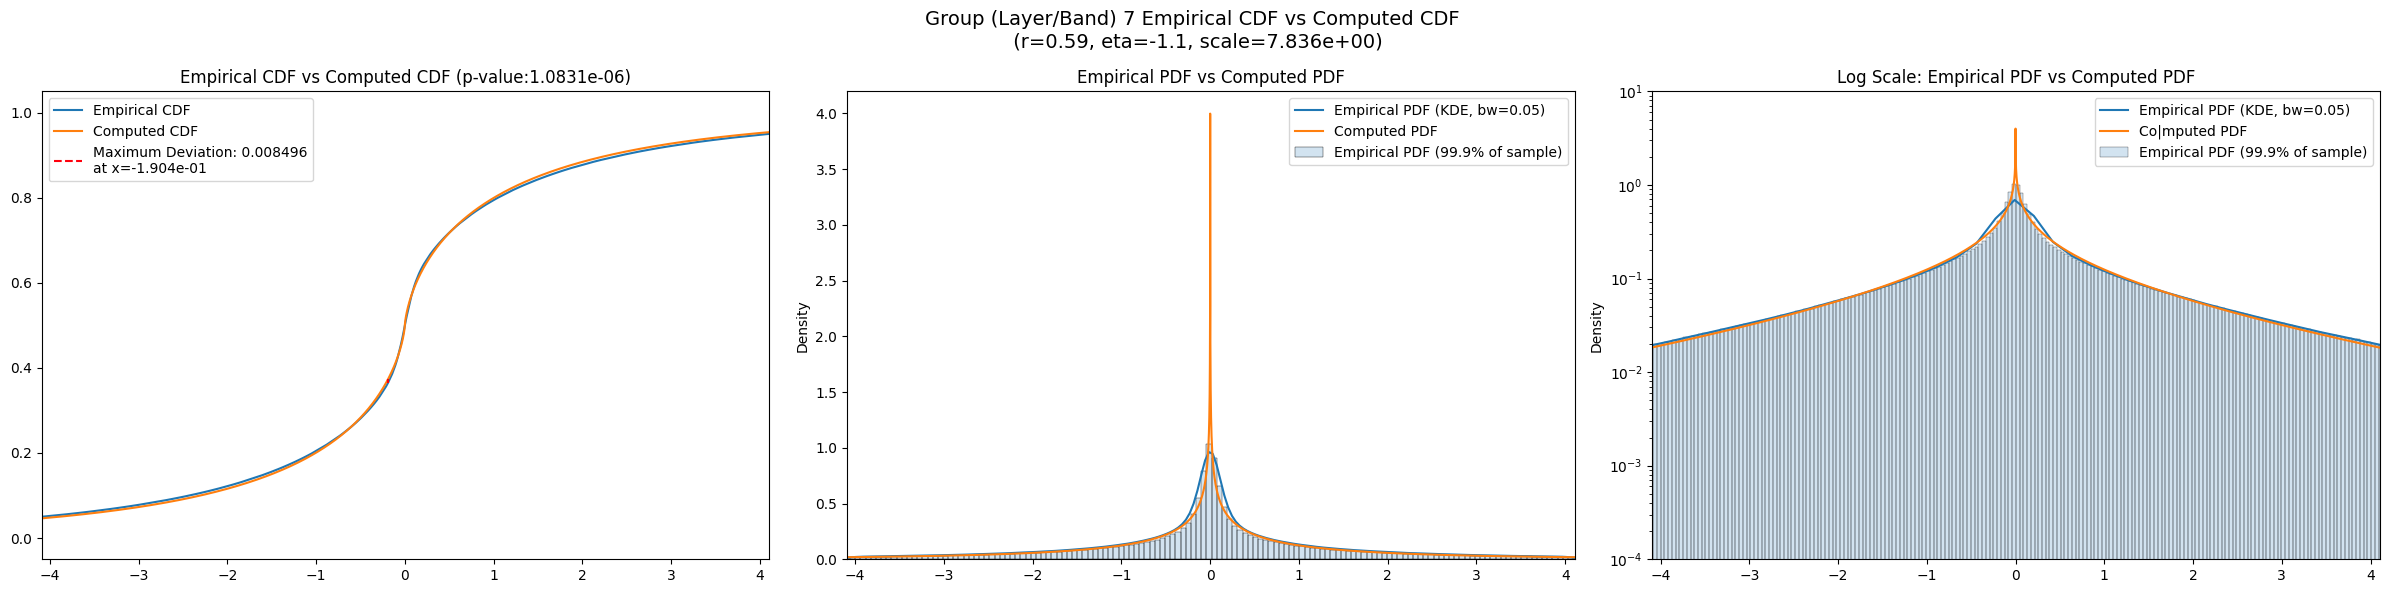

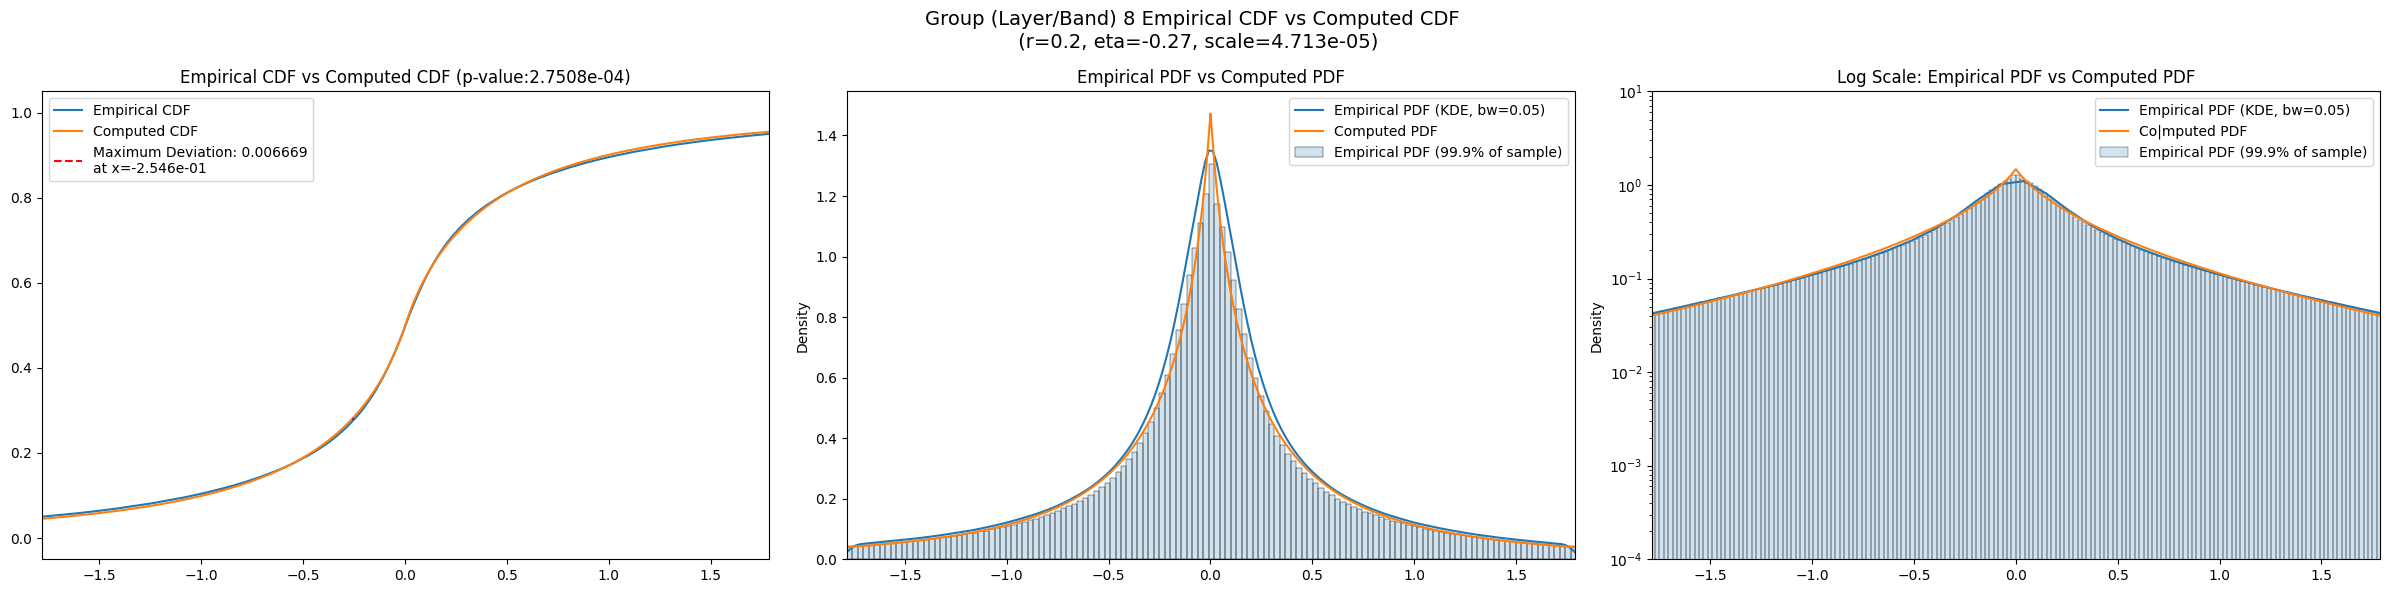

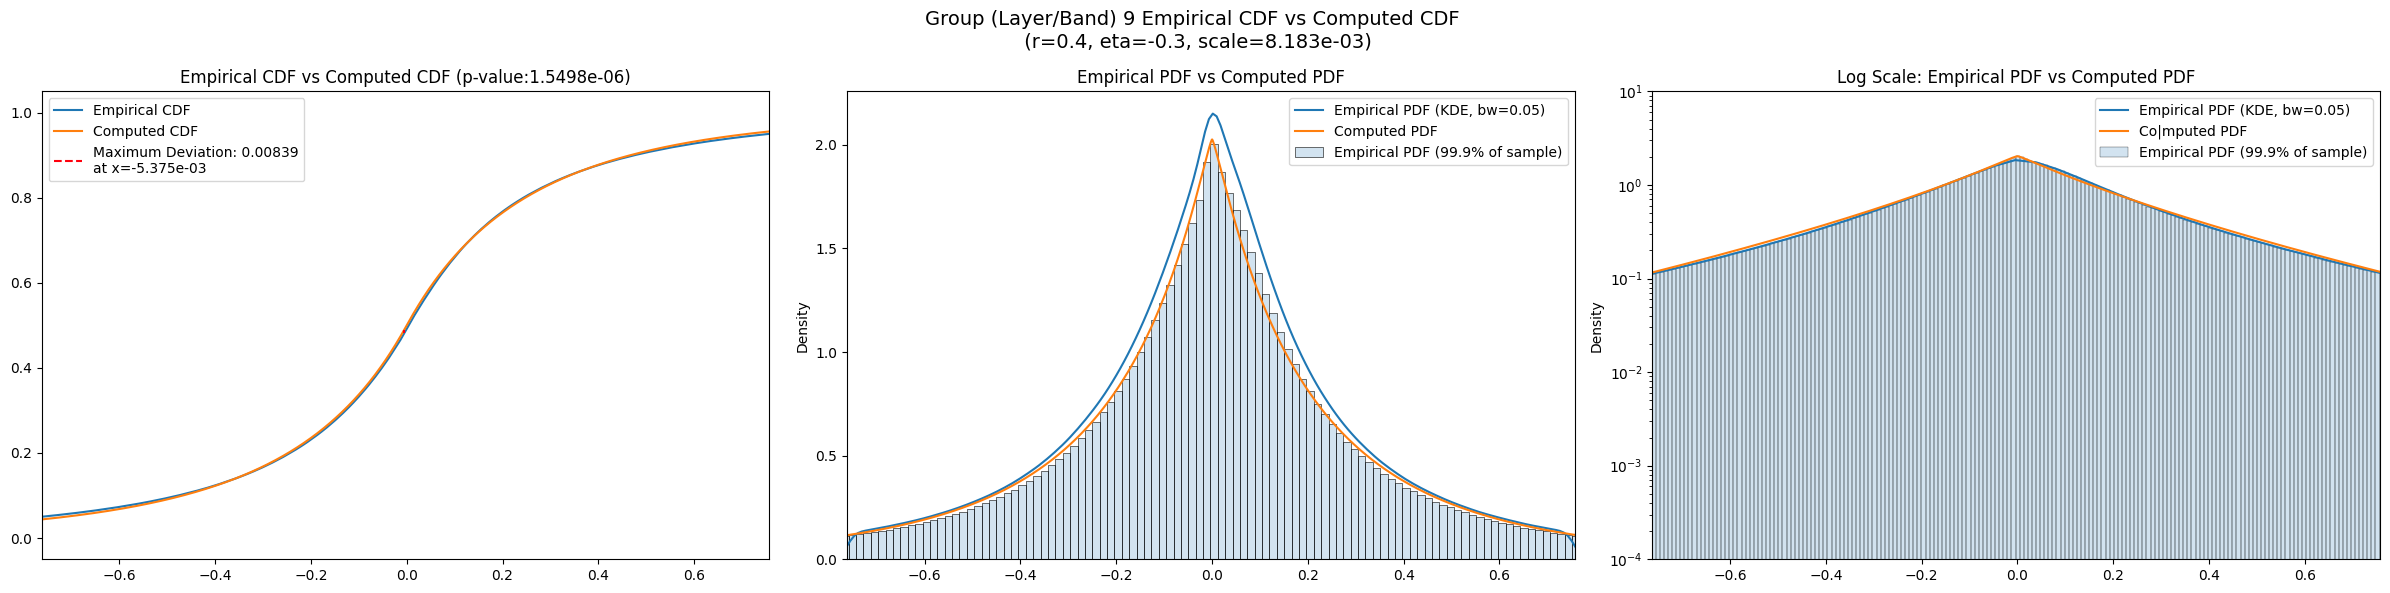

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
layer                                                                  
2      8327.673000  7757.876000  8938.270000    5.539157    3.577629   
3      1202.711800  1089.304400  1329.523300   13.088850    9.018444   
4       481.690160   438.480440   529.395800   11.107946    7.711442   
5       131.085340   119.751950   143.272900   10.210282    7.316702   
6        34.236774    31.205149    37.663357   11.394091    7.350032   
7         8.272123     7.386951     9.387478   19.578783   10.490964   
8         1.799252     1.550236     2.246931   49.430210   14.174963   
9         0.321161     0.266255     0.511087  205.948240   11.414248   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        8.374949        13604.0             0.009412        4.9         -1.0   
3       19.648750        54416.0             0.221461        0.3         -1.3   
4       20.912415       166649.0             0.133500        0.3         -1.3   
5       15.086034       574769.0             0.074350        1.4         -1.2   
6       22.886230      2125625.0             0.009092        7.2         -1.2   
7       55.204620      8502500.0             0.009025        0.6         -1.1   
8      222.789520     34010000.0             0.006509        0.2         -0.3   
9      832.416260    136040000.0             0.008378        0.4         -0.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       65.669300              0.041266          1.443940e-20   
3      ...        5.541380              0.221461          0.000000e+00   
4      ...        5.605080              0.142345          0.000000e+00   
5      ...        4.199740              0.105659          0.000000e+00   
6      ...        2.912040              0.070896          0.000000e+00   
7      ...        1.235380              0.076500          0.000000e+00   
8      ...        0.603819              0.062556          0.000000e+00   
9      ...        0.318291              0.044642          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          55.051600             0.022018             0.000004  46.080400   
3           5.270550             0.221461             0.000000   3.684020   
4           4.275530             0.133500             0.000000   3.211980   
5           3.291110             0.090756             0.000000   2.633940   
6           2.367540             0.051521             0.000000   1.903030   
7           1.045530             0.052193             0.000000   0.826086   
8           0.530523             0.035340             0.000000   0.420160   
9           0.280515             0.017571             0.000000   0.221552   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.027842   1.355270e-09          1.783634e-01  
3           0.221461   0.000000e+00          0.000000e+00  
4           0.133518   0.000000e+00          0.000000e+00  
5           0.093936   0.000000e+00          0.000000e+00  
6           0.055432   0.000000e+00         4.753084e-153  
7           0.055076   0.000000e+00          0.000000e+00  
8           0.034841   0.000000e+00          0.000000e+00  
9           0.018360   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.009412                 0.011632          0.009412   
3                 0.221461                 0.005819          0.221461   
4                 0.133500                 0.003326          0.133500   
5                 0.074350                 0.001791          0.074350   
6                 0.009092                 0.000931          0.009092   
7                 0.009025                 0.000466          0.008379   
8                 0.006509                 0.000233          0.006448   
9                 0.008378                 0.000116          0.008378   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.041266             0.022018       0.027842  
3                  0.221461             0.221461       0.221461  
4                  0.142345             0.133500       0.133518  
5                  0.105659             0.090756       0.093936  
6                  0.070896             0.051521       0.055432  
7                  0.076500             0.052193       0.055076  
8                  0.062556             0.035340       0.034841  
9                  0.044642             0.017571       0.018360

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             8327.673000          0.009412    4.90     -1.00  26486.933358   
3             1202.711800          0.221461    0.30     -1.30    271.435602   
4              481.690160          0.133500    0.30     -1.30    108.710880   
5              118.336250          0.074350    1.80     -1.23    570.898272   
6               30.675667          0.009092    7.20     -1.20    140.705393   
7                7.167654          0.008379    0.59     -1.10      7.835647   
8                1.568789          0.006448    0.20     -0.27      0.000047   
9                0.214158          0.008378    0.40     -0.30      0.008183   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    100.0  
6                    100.0  
7                    100.0  
8                     50.0  
9                    350.0

In [21]:
eng.quit()